# Multistep and RK methods

The archetype of all IVP solvers is **Euler's method**, which for fixed **step size** $\tau$ is defined by

$$
u_{i+1} = u_i + \tau f(t_i,u_i), \quad i=0,1,2,\ldots. 
$$

In [1]:
function euler(ivp,n)
    a,b = ivp.tspan
    τ = (b-a)/n
    t = [a+i*τ for i in 0:n]
    u₀ = ivp.u0
    u = Vector{typeof(u₀)}(undef,n+1)
    u[1] = u₀
    for i in 1:n
        u[i+1] = u[i] + τ*ivp.f(u[i],ivp.p,t[i])
    end
    return t,u
end

euler (generic function with 1 method)

In [2]:
using OrdinaryDiffEq, Plots
function predprey(u,params,t)
    rabbits,foxes = u 
    ⍺,β,γ,δ = params
    ∂ₜrabbits = ⍺*rabbits - β*rabbits*foxes
    ∂ₜfoxes = γ*rabbits*foxes - δ*foxes
    return [∂ₜrabbits,∂ₜfoxes]
end

u₀ = [40.,2.]
ivp = ODEProblem(predprey,u₀,(0.,40.),(0.2,0.1,0.05,0.3))
sol = solve(ivp,BS5())

t,u = euler(ivp,100)

([0.0, 0.4, 0.8, 1.2000000000000002, 1.6, 2.0, 2.4000000000000004, 2.8000000000000003, 3.2, 3.6  …  36.4, 36.800000000000004, 37.2, 37.6, 38.0, 38.400000000000006, 38.800000000000004, 39.2, 39.6, 40.0], [[40.0, 2.0], [40.0, 3.3600000000000003], [37.824, 5.6448], [32.309563392, 9.237602304], [22.955812574113068, 14.098347972143465], [11.846716233916014, 18.879326888549297], [3.8481323991899314, 21.086968228643062], [0.9101651654719225, 20.179440954032497], [0.24831341010736108, 18.125240523849754], [0.08814887157621937, 16.04022646665765]  …  [0.10779875442250741, 0.00046555977168183534], [0.11642064730576815, 0.0004106963343499457], [0.12573238654890595, 0.0003623690448897747], [0.13578915501182542, 0.00031979598999951054], [0.14665055041968114, 0.0002822889677447333], [0.15838093853995575, 0.0002492422482653087], [0.17104983461430404, 0.00022012268289755302], [0.18473231530550818, 0.00019446099991993633], [0.19950946360071875, 0.00017184414454458064], [0.21546884930745222, 0.000151908

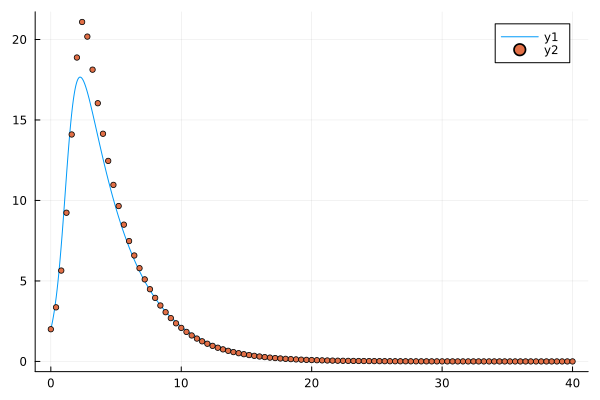

In [3]:
plot(t->sol(t,idxs=2),0,40)
scatter!(t,[u[2] for u in u],m=3)

There are two major ways to generalize from Euler.

## Multistep methods

The two major classes of IVP solvers are **multistage** and **multistep** methods. The multistage category is dominated by **Runge--Kutta** methods. 

A **multistep** method has the general form

```{math}
:label: multistep
u_{i+1} &= a_{k-1}u_i + \cdots + a_0 u_{i-k+1} \qquad \\ 
        & \qquad + \tau ( b_kf_{i+1} + \cdots + b_0 f_{i-k+1}),
```

where $\tau=t_{i+1}-t_i$ is the step size and the $a_j$ and $b_j$ are constants defining the particular method. Notable examples are **backward Euler**, 

$$
u_{k+1} = u_k + \tau f(t_{k+1},u_{k+1}), 
$$

and the **trapezoid formula**,

$$
u_{k+1} = u_k + \tfrac{1}{2}\tau \left[ f(t_{k},u_{k}) + f(t_{k+1},u_{k+1})\right].
$$

Other common examples are in the following tables.

(table-adams)=

```{table} Coefficients of Adams multistep formulas. All have $a_{k-1}=1$ and $a_{k-2} = \cdots = a_0 = 0$.

| name/order | steps $k$ |       $b_k$       |     $b_{k-1}$     |     $b_{k-2}$      |     $b_{k-3}$     |     $b_{k-4}$     |
|:----------:|:---------:|:-----------------:|:-----------------:|:------------------:|:-----------------:|:-----------------:|
|    AB1     |     1     |         0         |         1         |      (Euler)       |                   |                   |
|    AB2     |     2     |         0         |   $\frac{3}{2}$   |   $-\frac{1}{2}$   |                   |                   |
|    AB3     |     3     |         0         |  $\frac{23}{12}$  |  $-\frac{16}{12}$  |  $\frac{5}{12}$   |                   |
|    AB4     |     4     |         0         |  $\frac{55}{24}$  |  $-\frac{59}{24}$  |  $\frac{37}{24}$  |  $-\frac{9}{24}$  |
|    AM1     |     1     |         1         | (Backward Euler)  |                    |                   |                   |
|    AM2     |     1     |   $\frac{1}{2}$   |   $\frac{1}{2}$   |    (Trapezoid)     |                   |
|    AM3     |     2     |  $\frac{5}{12}$   |  $\frac{8}{12}$   |  $-\frac{1}{12}$   |                   |                   |
|    AM4     |     3     |  $\frac{9}{24}$   |  $\frac{19}{24}$  |  $-\frac{5}{24}$   |  $\frac{1}{24}$   |                   |
|    AM5     |     4     | $\frac{251}{720}$ | $\frac{646}{720}$ | $-\frac{264}{720}$ | $\frac{106}{720}$ | $-\frac{19}{720}$ |
```

(table-BD)=

```{table} Coefficients of backward differentiation formulas. All  have $b_k\neq 0$ and $b_{k-1} = \cdots = b_0 = 0$.

| name/order | steps $k$ | $a_{k-1}$       | $a_{k-2}$        | $a_{k-3}$       | $a_{k-4}$       | $b_k$           |
|:----------:|:---------:|:---------------:|:----------------:|:---------------:|:---------------:|:---------------:|
| BD1        | 1         | 1               | (Backward Euler) |                 |                 | 1               |
| BD2        | 2         | $\frac{4}{3}$   | $-\frac{1}{3}$   |                 |                 | $\frac{2}{3}$   |
| BD3        | 3         | $\frac{18}{11}$ | $-\frac{9}{11}$  | $\frac{2}{11}$  |                 | $\frac{6}{11}$  |
| BD4        | 4         | $\frac{48}{25}$ | $-\frac{36}{25}$ | $\frac{16}{25}$ | $-\frac{3}{25}$ | $\frac{12}{25}$ |
```

Most multistep methods have an inconvenience requiring a short history of values to get started, but this is taken care of for you in software, and these methods can be more efficient than RK methods, especially for high-accuracy solutions.


## Runge--Kutta

The other major generalization of Euler's method are the **multistage** methods, which are dominated by **Runge--Kutta** methods of the form


```{math}
  :label: rk
  \begin{split}
    k_1 &= h f(t_i,u_i),\\
    k_2 &= h f(t_i+c_1h,u_i + a_{11}k_1),\\
    k_3 &= h f(t_i+c_2h, u_i + a_{21}k_1 + a_{22}k_2),\\
    &\vdots\\
    k_s &= h f(t_i + c_{s-1}h, u_i + a_{s-1,1}k_1 + \cdots +
    a_{s-1,s-1}k_{s-1}),\\
    \mathbf{u}_{i+1} &= u_i + b_1k_1 + \cdots + b_s k_s.
  \end{split}
```

This recipe is completely determined by the number of stages $s$ and the constants $a_{ij}$, $b_j$, and $c_i$.  Often an RK method is presented as just a table of these numbers, as in

```{math}
  \begin{array}{r|ccccc}
    0 &  &  & & & \\
    c_1 & a_{11} & & &\\
    c_2 & a_{21} & a_{22} & & &\\
    \vdots & \vdots & & \ddots & &\\
    c_{s-1} & a_{s-1,1} & \cdots & & a_{s-1,s-1}&\\[1mm] \hline
    \rule{0pt}{2.25ex}    & b_1 & b_2 & \cdots & b_{s-1} & b_s
  \end{array}
```

The best-known RK method is given by

```{math}
  :label: rk4
  \begin{array}{r|cccc}
    \rule{0pt}{2.75ex}0 &  & & & \\
    \rule{0pt}{2.75ex}\frac{1}{2} & \frac{1}{2} & & &\\
    \rule{0pt}{2.75ex}\frac{1}{2} & 0 & \frac{1}{2} & &\\
    \rule{0pt}{2.75ex}1 & 0 & 0 & 1\\[1mm] \hline
    \rule{0pt}{2.75ex}& \frac{1}{6} & \frac{1}{3} & \frac{1}{3} & \frac{1}{6}
  \end{array}
```

This formula is often referred to as *the* fourth-order RK method, even though there are many others, and we refer to it as **RK4**.  Written out, the recipe is as follows.

::::{prf:definition} Fourth-order Runge–Kutta method (RK4)
```{math}
  :label: rk4def
  \begin{split}
    k_1 &= hf(t_i,u_i), \\
    k_2 &= hf(t_i+h/2,u_i+k_1/2),\\
    k_3 &= hf(t_i+h/2,u_i+k_2/2),\\
    k_4 &= hf(t_i+h,u_i+k_3),\\
    u_{i+1} &= u_i + \frac{1}{6} k_1 + \frac{1}{3} k_2 + \frac{1}{3} k_3 + \frac{1}{6} k_4.
  \end{split}
```
::::


## Implicit methods

More important than the multistep/RK split is the division into **explicit** and **implicit** formulas. Like an explicit function, an explicit method allows you to compute the next solution value in a finite number of operations in a well-defined manner. An implicit method defines the next solution value implicitly as the solution of an equation that is nonlinear if the ODE is nonlinear. A multistep formula in the form given above is implicit if and only if $b_k\neq 0$. An implicit RK formula can have $a_{ij}\neq 0$ for $i\le j$.

For an implicit method used on a nonlinear IVP, an iteration is needed to find the next value *at each time step*, which greatly increases the computational cost per step. Hence, the only reason to use an implicit method is if it can take a drastically smaller number of steps for some reason....